## NLP Tutorial

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import warnings
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.ensemble import RandomForestClassifier
#import xgboost, numpy, textblob, string
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import string


Import Data from Kaggle

In [ ]:
nlp_train = '/kaggle/input/Real or Not? NLP with Disaster Tweets/train.csv'


Connect to GCS Storage Client and Define Some Helper Functions

In [ ]:
from google.cloud import storage
storage_client = storage.Client(project='NLPKAG')

def create_bucket(dataset_name):
    """Creates a new bucket. https://cloud.google.com/storage/docs/ """
    bucket = storage_client.create_bucket(dataset_name)
    print('Bucket {} created'.format(bucket.name))

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket. https://cloud.google.com/storage/docs/ """
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))
    
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket. https://cloud.google.com/storage/docs/"""
    blobs = storage_client.list_blobs(bucket_name)
    for blob in blobs:
        print(blob.name)
        
def download_to_kaggle(bucket_name,destination_directory,file_name):
    """Takes the data from your GCS Bucket and puts it into the working directory of your Kaggle notebook"""
    os.makedirs(destination_directory, exist_ok = True)
    full_file_path = os.path.join(destination_directory, file_name)
    blobs = storage_client.list_blobs(bucket_name)
    for blob in blobs:
        blob.download_to_filename(full_file_path)

Create a new GCS Bucket

In [ ]:
bucket_name = 'wisconsinbreastcancer_test'         
try:
    create_bucket(bucket_name)   
except:
    pass

Upload your data to a GCS Bucket

In [ ]:
local_data = '/kaggle/input/Real or Not? NLP with Disaster Tweets/train.csv'
file_name = 'nlp_train.csv' 
bucket_name = 'nlp_auto'
upload_blob(bucket_name, local_data, file_name)
print('Data inside of',bucket_name,':')
list_blobs(bucket_name)

 Download your data from the GCS Bucket

In [ ]:
destination_directory = '/kaggle/working/breastcancerwisconsin/'       
file_name = 'data.csv'
download_to_kaggle(bucket_name,destination_directory,file_name)

In [ ]:
os.listdir('/kaggle/working/breastcancerwisconsin/')

In [ ]:
full_file_path = os.path.join(destination_directory, file_name)
new_file = pd.read_csv(full_file_path)
pp.ProfileReport(new_file)

In [ ]:
# Set your own project id here
PROJECT_ID = 'NLPKAG'
from google.cloud import automl_v1beta1 as automl
automl_client = automl.AutoMlClient()

**#Reading the data**

In [16]:
#train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
#test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
import os
print(os.getcwd())
# Out: /Users/shane/Documents/blog
# Display all of the files found in your current working directory
print(os.listdir(os.getcwd()))

C:\Users\vreddyj\Desktop\BM_2018\Ineuron\Natural-Language-Processing-master\NLP-Kaggle
['.ipynb_checkpoints', 'NLP with Disaster Tweets_v1.ipynb', 'NLP_test .csv', 'NLP_train .csv', 'submission (1).csv']


In [17]:
file_path = 'C:\\Users\\vreddyj\\pandas\\data\\NLP_train.csv'
file_path2 = 'C:\\Users\\vreddyj\\pandas\\data\\NLP_test.csv'

train_df = pd.read_csv(file_path)
test_df = pd.read_csv(file_path2)

In [18]:
train_df.info()
train_df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [20]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
test_df

**Data Analysis******

In [ ]:
print("Number of records and columns  -  train data", train_df.shape)
print("Field names :", train_df.columns.values)
#HANDLING MISSING DATA
total = train_df.isnull().sum().sort_values(ascending = False)
print("column wise total null counts",'\n',total)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
print("column wise total null count percentages",'\n', percent)

In [ ]:
#to see the missing values
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="black",alpha=0.8)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percent of missing values', fontsize=14)
    plt.title('Percent missing data by feature', fontsize=16)
    return ms

missingdata(train_df)
# rnd spend has two null values

In [ ]:
y_counts = train_df['target'].value_counts()
print ("target value distribution",'\n', y_counts)
print ("target value distribution percentage",'\n',train_df['target'].value_counts(normalize=True))
plt.xlabel('Number of values')
plt.ylabel('distinct target values')
plt.title('target value distribution')
train_df['target'].value_counts().plot(kind='barh')



In [ ]:
keyword_counts = train_df['keyword'].value_counts()
print ("keyword value distribution",'\n', keyword_counts.head(15))
print ("keyword value distribution",'\n', keyword_counts.tail(15))
print ("keyword value distribution percentage",'\n',train_df['keyword'].value_counts(normalize=True))
sns.distplot(keyword_counts.values)
plt.title('distribution of unique words in keyword')
plt.xlabel('Number of unique words in keyword feature')
plt.show()

In [ ]:
text_lists = train_df["text"].str.split(' ', expand=True)

word_count = train_df.text.str.split().apply(len).value_counts()
print('total number of words present in each text feature')
print(word_count)
text_lists.head()

to see the null values

In [ ]:
disaster_word_count = train_df[train_df['target']==1]['text'].str.split().apply(len)
disaster_word_count = disaster_word_count.values
print('disaster class word count', disaster_word_count)
not_disaster_word_count = train_df[train_df['target']==0]['text'].str.split().apply(len)
not_disaster_word_count = not_disaster_word_count.values
print('non disaster class word count', not_disaster_word_count)

In [ ]:
plt.figure(figsize=(10,3))
sns.distplot(disaster_word_count, hist=False, label="Disaster")
sns.distplot(not_disaster_word_count, hist=False, label="Not a Disaster")
plt.title('Words for each text of the tweets')
plt.xlabel('Number of words in each text')
plt.legend()
plt.show()

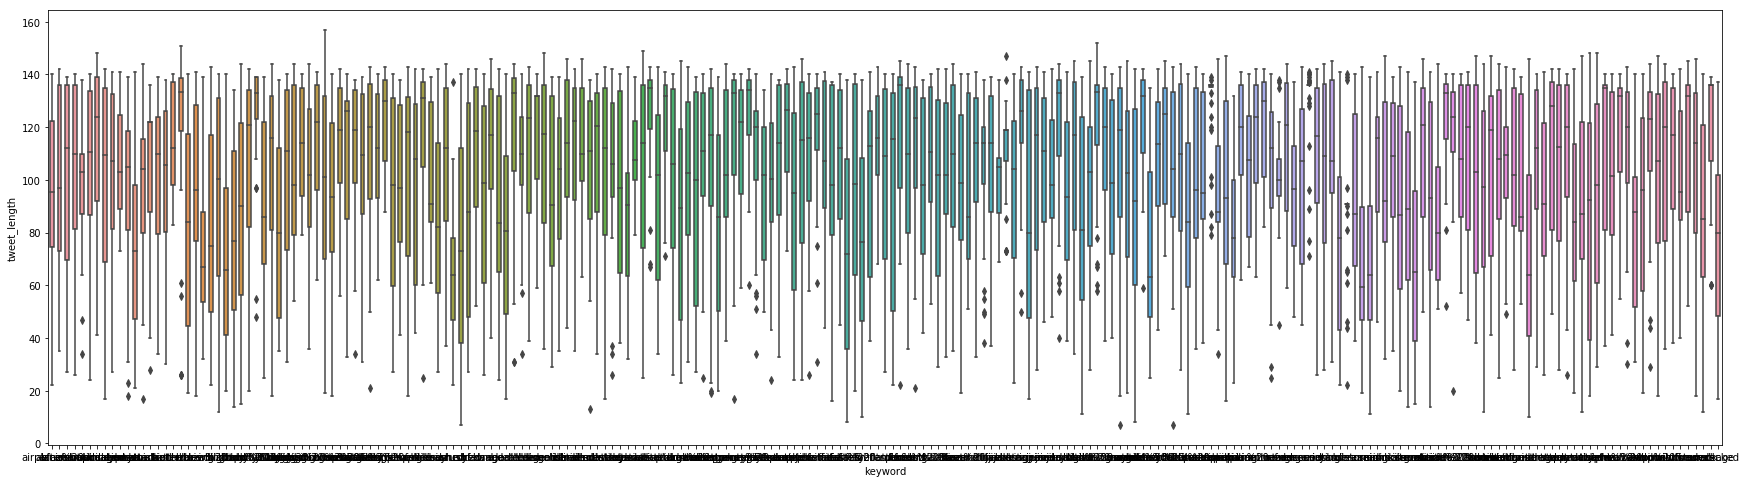

In [22]:
train_df['tweet_length'] = train_df['text'].str.len()
test_df['tweet_length'] = test_df['text'].str.len()
plt.figure(figsize=(30,8))
sns.boxplot(data=train_df, x='keyword', y='tweet_length', width=.5);

In [36]:
#Tokenization (a list of tokens), will be used as the analyzer
#1.Punctuations are [!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]
#2.Stop words in natural language processing, are useless words (data).
def process_text(text):
    '''
    What will be covered:
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    text = text.replace('http', '')
    text = text.replace('https', '')
    #1
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #2
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    #3
    return clean_words

In [37]:
#Show the Tokenization (a list of tokens )
train_df['text_parsed'] = train_df['text'].head().apply(process_text)
test_df['text_parsed'] = test_df['text'].head().apply(process_text)

In [69]:
train_df.head(5)

,id,keyword,location,text,text_Parsed,tweet_length,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,deeds reason #earthquake may allah forgiv...,69,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada,38,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,residents ask 'shelter place' notify off...,133,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",65,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,get send photo ruby #alaska smoke #wildfi...,88,1


In [39]:
test_df.head(5)

,id,keyword,location,text,tweet_length,text_parsed
0,0,NaN,NaN,Just happened a terrible car crash,34,"[happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,"[Heard, earthquake, different, cities, stay, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,"[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40,"[Apocalypse, lighting, Spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45,"[Typhoon, Soudelor, kills, 28, China, Taiwan]"


In [41]:
#Convert string to integer counts, learn the vocabulary dictionary and return term-document matrix
messages_bow = CountVectorizer.fit_transform(train_df['text_parsed'])
messages_bowt = CountVectorizer.fit_transform(test_df['text_parsed'])

TypeError: fit_transform() missing 1 required positional argument: 'raw_documents'

In [35]:
text = 'http how are you'
text = text.replace('http', '')
text

' how are you'

In [70]:
# \r and \n
train_df['text_Parsed_1'] = train_df['text'].str.replace("\r", " ")
test_df['text_Parsed_1'] = test_df['text'].str.replace("\r", " ")

In [71]:
train_df['text_Parsed_1'] = train_df['text_Parsed_1'].str.replace("    ", " ")
# " when quoting text
train_df['text_Parsed_1'] = train_df['text_Parsed_1'].str.replace('"', '')

train_df['text_Parsed_1'] = train_df['text_Parsed_1'].str.replace('http://', '')
train_df['text_Parsed_1'] = train_df['text_Parsed_1'].str.replace('https://', '')
# Lowercasing the text
train_df['text_Parsed_1'] = train_df['text_Parsed_1'].str.lower()

punctuation_signs = list("?:!.,;!#$%&'()*+,-./:;<=>?@[\]^_`{|}~")
train_df['text_Parsed_2'] = train_df['text_Parsed_1']

for punct_sign in punctuation_signs:
    train_df['text_Parsed_3'] = train_df['text_Parsed_2'].str.replace(punct_sign, '')
#We'll also remove possessive pronoun terminations:   
#train_df['text_Parsed_3'] = train_df['text_Parsed_3'].str.replace("'s", '')

In [72]:
test_df['text_Parsed_1'] = test_df['text_Parsed_1'].str.replace("    ", " ")
# " when quoting text
test_df['text_Parsed_1'] = test_df['text_Parsed_1'].str.replace('"', '')

test_df['text_Parsed_1'] = test_df['text_Parsed_1'].str.replace('http://', '')
test_df['text_Parsed_1'] = test_df['text_Parsed_1'].str.replace('https://', '')
# Lowercasing the text
test_df['text_Parsed_1'] = test_df['text_Parsed_1'].str.lower()

punctuation_signs = list("?:!.,;!#$%&'()*+,-./:;<=>?@[\]^_`{|}~")
test_df['text_Parsed_2'] = test_df['text_Parsed_1']

for punct_sign in punctuation_signs:
    test_df['text_Parsed_3'] = test_df['text_Parsed_2'].str.replace(punct_sign, '')
#We'll also remove possessive pronoun terminations:   
#train_df['text_Parsed_3'] = train_df['text_Parsed_3'].str.replace("'s", '')

In [73]:
train_df.head(10)
test_df.head(10)


,id,keyword,location,text,text_Parsed,tweet_length,text_Parsed_1,text_Parsed_2,text_Parsed_3
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash,34,just happened a terrible car crash,just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","hear #earthquake different cities, stay safe...",64,"heard about #earthquake is different cities, s...","heard about #earthquake is different cities, s...","heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","forest fire spot pond, geese flee across ...",96,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting. #spokane #wildfires,40,apocalypse lighting. #spokane #wildfires,apocalypse lighting. #spokane #wildfires,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,45,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 in china and taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake,' shaking...' earthquake,34,we're shaking...it's an earthquake,we're shaking...it's an earthquake,we're shaking...it's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...,' probably still show life arsenal yesterda...,72,they'd probably still show more life than arse...,they'd probably still show more life than arse...,they'd probably still show more life than arse...
7,22,NaN,NaN,Hey! How are you?,hey! ?,17,hey! how are you?,hey! how are you?,hey! how are you?
8,27,NaN,NaN,What a nice hat?,nice hat?,16,what a nice hat?,what a nice hat?,what a nice hat?
9,29,NaN,NaN,Fuck off!,fuck !,9,fuck off!,fuck off!,fuck off!


In [42]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vreddyj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vreddyj\AppData\Roaming\nltk_data...


------------------------------------------------------------


[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [74]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [75]:
nrows = len(train_df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = train_df.loc[row]['text_Parsed_3']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)
train_df['text_Parsed_4'] = lemmatized_text_list
train_df.head(10)




,id,keyword,location,text,text_Parsed,tweet_length,target,text_Parsed_1,text_Parsed_2,text_Parsed_3,text_Parsed_4
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,deeds reason #earthquake may allah forgiv...,69,1,our deeds are the reason of this #earthquake m...,our deeds are the reason of this #earthquake m...,our deeds are the reason of this #earthquake m...,our deeds be the reason of this #earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada,38,1,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,residents ask 'shelter place' notify off...,133,1,all residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...,all residents ask to 'shelter in place' be be ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",65,1,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,get send photo ruby #alaska smoke #wildfi...,88,1,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby #alaska as ...,just get send this photo from ruby #alaska as ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,#rockyfire update => california hwy. 20 close ...,110,1,#rockyfire update => california hwy. 20 closed...,#rockyfire update => california hwy. 20 closed...,#rockyfire update => california hwy. 20 closed...,#rockyfire update => california hwy. 20 close ...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,#flood #disaster heavy rain cause flash flood ...,95,1,#flood #disaster heavy rain causes flash flood...,#flood #disaster heavy rain causes flash flood...,#flood #disaster heavy rain causes flash flood...,#flood #disaster heavy rain cause flash flood ...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,' top hill see fire woods...,59,1,i'm on top of the hill and i can see a fire in...,i'm on top of the hill and i can see a fire in...,i'm on top of the hill and i can see a fire in...,i'm on top of the hill and i can see a fire in...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,' emergency evacuation happen build across...,79,1,there's an emergency evacuation happening now ...,there's an emergency evacuation happening now ...,there's an emergency evacuation happening now ...,there's an emergency evacuation happen now in ...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,' afraid tornado come area...,52,1,i'm afraid that the tornado is coming to our a...,i'm afraid that the tornado is coming to our a...,i'm afraid that the tornado is coming to our a...,i'm afraid that the tornado be come to our are...


In [77]:
lemmatized_text_list.clear()
nrowstest = len(test_df)
for row in range(0, nrowstest):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = test_df.loc[row]['text_Parsed_3']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)
test_df['text_Parsed_4'] = lemmatized_text_list
test_df.head(10)
lemmatized_text_list.clear()

In [78]:
# Downloading the stop words list
nltk.download('stopwords')

# Loading the stop words in english
stop_words = list(stopwords.words('english'))

stop_words[0:20]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vreddyj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [79]:
train_df['text_Parsed_4'] = train_df['text_Parsed_4']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    train_df['text_Parsed_4'] = train_df['text_Parsed_4'].str.replace(regex_stopword, '')

In [80]:
test_df['text_Parsed_4'] = test_df['text_Parsed_4']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    test_df['text_Parsed_4'] = test_df['text_Parsed_4'].str.replace(regex_stopword, '')

In [86]:
test_df.head(10)

,id,keyword,location,text,text_Parsed,tweet_length
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","hear #earthquake different cities, stay safe...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","forest fire spot pond, geese flee across ...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting. #spokane #wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,45
5,12,NaN,NaN,We're shaking...It's an earthquake,' shaking...' earthquake,34
6,21,NaN,NaN,They'd probably still show more life than Arse...,' probably still show life arsenal yesterda...,72
7,22,NaN,NaN,Hey! How are you?,hey! ?,17
8,27,NaN,NaN,What a nice hat?,nice hat?,16
9,29,NaN,NaN,Fuck off!,fuck !,9


In [81]:

train_df.loc[100]['text'],train_df.loc[100]['text_Parsed_4']

('.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad',
 '.@norwaymfa #bahrain police  previously die   road accident    kill  explosion .co/gfjfgtodad')

In [82]:
list_columns = ["id", "keyword", "location", "text","text_Parsed_4","tweet_length","target"]
train_df = train_df[list_columns]

train_df = train_df.rename(columns={'text_Parsed_4': 'text_Parsed'})
train_df.head(10)

,id,keyword,location,text,text_Parsed,tweet_length,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,deeds reason #earthquake may allah forgiv...,69,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada,38,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,residents ask 'shelter place' notify off...,133,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",65,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,get send photo ruby #alaska smoke #wildfi...,88,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,#rockyfire update => california hwy. 20 close ...,110,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,#flood #disaster heavy rain cause flash flood ...,95,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,' top hill see fire woods...,59,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,' emergency evacuation happen build across...,79,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,' afraid tornado come area...,52,1


In [87]:
list_columns = ["id", "keyword", "location", "text","text_Parsed","tweet_length"]
test_df = test_df[list_columns]

#test_df = test_df.rename(columns={'text_Parsed_4': 'text_Parsed'})
test_df.head(10)

,id,keyword,location,text,text_Parsed,tweet_length
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","hear #earthquake different cities, stay safe...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","forest fire spot pond, geese flee across ...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting. #spokane #wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,45
5,12,NaN,NaN,We're shaking...It's an earthquake,' shaking...' earthquake,34
6,21,NaN,NaN,They'd probably still show more life than Arse...,' probably still show life arsenal yesterda...,72
7,22,NaN,NaN,Hey! How are you?,hey! ?,17
8,27,NaN,NaN,What a nice hat?,nice hat?,16
9,29,NaN,NaN,Fuck off!,fuck !,9


In [88]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text_Parsed'], 
                                                    train_df['target'], 
                                                    test_size=0.15, 
                                                    random_state=8)

In [89]:
X_ftest = test_df['text_Parsed']
X_ftest

0                              happen  terrible car crash
1       hear  #earthquake  different cities, stay safe...
2          forest fire  spot pond, geese  flee across ...
3                apocalypse lighting. #spokane #wildfires
4                 typhoon soudelor kill 28  china  taiwan
5                               ' shaking...'  earthquake
6       ' probably still show  life  arsenal  yesterda...
7                                                hey!   ?
8                                               nice hat?
9                                                  fuck !
10                                           ' like cold!
11                                       nooooooooo! '  !
12                                              ' tell  !
13                                                     ?!
14                                               awesome!
15      birmingham wholesale market  ablaze bbc news -...
16            @sunkxssedharry   wear short  race ablaze ?
17      #previ

In [90]:
# Parameter selection
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [91]:

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

#final TEST File
features_ftest = tfidf.fit_transform(X_ftest).toarray()
print(features_ftest.shape)

(6471, 300)
(1142, 300)
(3263, 300)


In [93]:

#Create and train the Naive Bayes classifier
#The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification)
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(features_train, labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [94]:
#Print the predictions
y_pred = (classifier.predict(features_test))
df1 = pd.DataFrame({'Actual':  labels_test, 'Predicted': y_pred,'Diff': (labels_test-y_pred)})
df1.head()


,Actual,Predicted,Diff
4055,0,1,-1
5199,0,0,0
5735,1,1,0
5263,1,1,0
764,0,0,0


In [95]:
#Evaluate the model on the training data set
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
pred = classifier.predict(features_train)
print(classification_report(y_train ,pred ))
print('Confusion Matrix: \n',confusion_matrix(y_train,pred))
print()
print('Accuracy: ', accuracy_score(y_train,pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      3691
           1       0.79      0.62      0.70      2780

   micro avg       0.77      0.77      0.77      6471
   macro avg       0.77      0.75      0.75      6471
weighted avg       0.77      0.77      0.76      6471

Confusion Matrix: 
 [[3243  448]
 [1052 1728]]

Accuracy:  0.7681965693092258


In [ ]:

#Print the predictions
print('Predicted value: ',classifier.predict(features_test))

#Print Actual Label
print('Actual value: ',y_test.values)

In [97]:
#Evaluate the model on the test data set
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
pred_test = classifier.predict(features_test)
print(classification_report(y_test ,pred_test ))

print('Confusion Matrix: \n', confusion_matrix(y_test,pred_test))
print()
print('Accuracy: ', accuracy_score(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78       651
           1       0.74      0.58      0.65       491

   micro avg       0.73      0.73      0.73      1142
   macro avg       0.74      0.72      0.72      1142
weighted avg       0.74      0.73      0.73      1142

Confusion Matrix: 
 [[552  99]
 [205 286]]

Accuracy:  0.7338003502626971


In [99]:
# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier
# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=10, max_depth = 5, random_state = 10)
    gb.fit(features_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(features_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(features_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.658
Accuracy score (validation): 0.645

Learning rate:  0.1
Accuracy score (training): 0.705
Accuracy score (validation): 0.667

Learning rate:  0.25
Accuracy score (training): 0.756
Accuracy score (validation): 0.706

Learning rate:  0.5
Accuracy score (training): 0.771
Accuracy score (validation): 0.701

Learning rate:  0.75
Accuracy score (training): 0.785
Accuracy score (validation): 0.716

Learning rate:  1
Accuracy score (training): 0.785
Accuracy score (validation): 0.720



In [106]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(features_train,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(features_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  73.81786339754815


### Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [100]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. 
testing_data = count_vector.transform(X_test)

In [101]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [103]:
pred = naive_bayes.predict(training_data)
print(classification_report(y_train ,pred ))
print('Confusion Matrix: \n',confusion_matrix(y_train,pred))
print()
print('Accuracy: ', accuracy_score(y_train,pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3691
           1       0.94      0.88      0.91      2780

   micro avg       0.92      0.92      0.92      6471
   macro avg       0.93      0.92      0.92      6471
weighted avg       0.92      0.92      0.92      6471

Confusion Matrix: 
 [[3531  160]
 [ 332 2448]]

Accuracy:  0.923968474733426


In [104]:
pred_test = naive_bayes.predict(testing_data)
print(classification_report(y_test ,pred_test ))
print('Confusion Matrix: \n',confusion_matrix(y_test,pred_test))
print()
print('Accuracy: ', accuracy_score(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       651
           1       0.77      0.72      0.74       491

   micro avg       0.78      0.78      0.78      1142
   macro avg       0.78      0.78      0.78      1142
weighted avg       0.78      0.78      0.78      1142

Confusion Matrix: 
 [[544 107]
 [139 352]]

Accuracy:  0.7845884413309983


In [105]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(training_data,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(testing_data)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  76.18213660245185


In [ ]:
#final TEST File
features_ftest = tfidf.fit_transform(X_ftest).toarray()
print(features_ftest.shape)

In [ ]:
target_cat_codes = {
    'No disaster': 0,
    'disaster': 1
}

In [ ]:

from sklearn.feature_selection import chi2
import numpy as np

for Product, target in sorted(target_cat_codes.items()):
    features_chi2 = chi2(features_train, labels_train == target)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' target 1 means disaster, 0 means no disaster:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

In [ ]:
bigrams

In [ ]:
unigrams

In [ ]:
print(features_train.shape)
print(features_test.shape)

In [ ]:

svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

In [ ]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

In [ ]:

# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

In [ ]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

### Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a RandomForestClassifier connection. So let's build a RandomForestClassifier and see!

In [51]:
#using random forest
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(features_train, labels_train);
y_pred = rf.predict(features_test)
df4 = pd.DataFrame({'Actual':  labels_test, 'Predicted': y_pred,'Diff': (labels_test-y_pred)})
df4.head()

,Actual,Predicted,Diff
4055,0,1,-1
5199,0,0,0
5735,1,1,0
5263,1,1,0
764,0,0,0


In [52]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, rf.predict(features_train)))

The training accuracy is: 
0.9400401792613198


In [53]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, y_pred))

The test accuracy is: 
0.7092819614711033


In [54]:
# Classification report
print("Classification report")
print(classification_report(labels_test,y_pred))

Classification report
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       651
           1       0.69      0.60      0.64       491

    accuracy                           0.71      1142
   macro avg       0.70      0.70      0.70      1142
weighted avg       0.71      0.71      0.71      1142



In [57]:
conf_matrix = confusion_matrix(labels_test, y_pred)
print(conf_matrix)

[[517 134]
 [198 293]]


In [63]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [64]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 23.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=8,
                                              verbose=0, warm_start=False),
  


The best hyperparameters turn out to be:

In [65]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.7529650436953808


In [66]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [60]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = rf.predict(features_ftest)

In [68]:
#Now, we can fit the model to our training data:
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

In [69]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

The training accuracy is: 
0.8385102766187607
Classification report
              precision    recall  f1-score   support

           0       0.71      0.85      0.78       651
           1       0.74      0.55      0.63       491

    accuracy                           0.72      1142
   macro avg       0.73      0.70      0.70      1142
weighted avg       0.72      0.72      0.71      1142



In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, y_pred))

In [70]:
conf_matrix = confusion_matrix(labels_test, y_pred)
print(conf_matrix)

[[517 134]
 [198 293]]


In [71]:
sample_submission["target"] = best_rfc.predict(features_ftest)

In [74]:
y_pred = best_rfc.predict(features_test)
df4 = pd.DataFrame({'Actual':  labels_test, 'Predicted': y_pred,'Diff': (labels_test-y_pred)})
df4.head()

,Actual,Predicted,Diff
4055,0,1,-1
5199,0,0,0
5735,1,1,0
5263,1,1,0
764,0,0,0


Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [75]:
scores = model_selection.cross_val_score(best_rfc, features_train, labels_train, cv=3, scoring="f1")
scores

array([0.66989703, 0.6689936 , 0.69792285])

In [72]:
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,0
3,9,0
4,11,0


Now, The predicted results will be written to the submissions file

In [73]:
sample_submission.to_csv("submission.csv", index=False)

Now, in the viewer, you can submit the above file to the competition! Good luck!